In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab
import seaborn

from collections import Counter
from scipy.special import binom

In [2]:
fcs = pd.read_csv('../data/arC9_foldchange.csv')
ss = pd.read_csv('../data/Cas9_merged_stride.csv')

In [3]:
secondary_structure_elts_4UN3 = []
secondary_structure_elts_4CMP = []
secondary_structure_elts_4OO8 = []
for i, row in fcs.iterrows():
    if row['P-value'] < 0.05 and row['Fold Change'] > 3:
        ss_data = ss[ss.PDBResidueNum == row.AA]
        ss_val = np.NAN
        if ss_data.size:
            ss_val = ss_data.SecondaryStructure_4UN3.values[0]
            secondary_structure_elts_4UN3.append(ss_val)
            
            ss_val = ss_data.SecondaryStructure_4CMP.values[0]
            secondary_structure_elts_4CMP.append(ss_val)
            
            ss_val = ss_data.SecondaryStructure_4OO8.values[0]
            secondary_structure_elts_4OO8.append(ss_val)

overall_4CMP = Counter(ss.SecondaryStructure_4CMP.values)
overall_4UN3 = Counter(ss.SecondaryStructure_4OO8.values)
overall_4OO8 = Counter(ss.SecondaryStructure_4OO8.values)

keys = sorted(overall_4CMP.keys())
overall_4CMP = np.array([float(overall_4CMP[k]) for k in keys])
overall_4UN3 = np.array([float(overall_4UN3[k]) for k in keys])
overall_4OO8 = np.array([float(overall_4OO8[k]) for k in keys])

overall_4CMP /= float(overall_4CMP.sum())
overall_4UN3 /= float(overall_4UN3.sum())
overall_4OO8 /= float(overall_4OO8.sum())

overall_4CMP_d = dict(zip(keys, overall_4CMP))
overall_4UN3_d = dict(zip(keys, overall_4UN3))
overall_4OO8_d = dict(zip(keys, overall_4OO8))

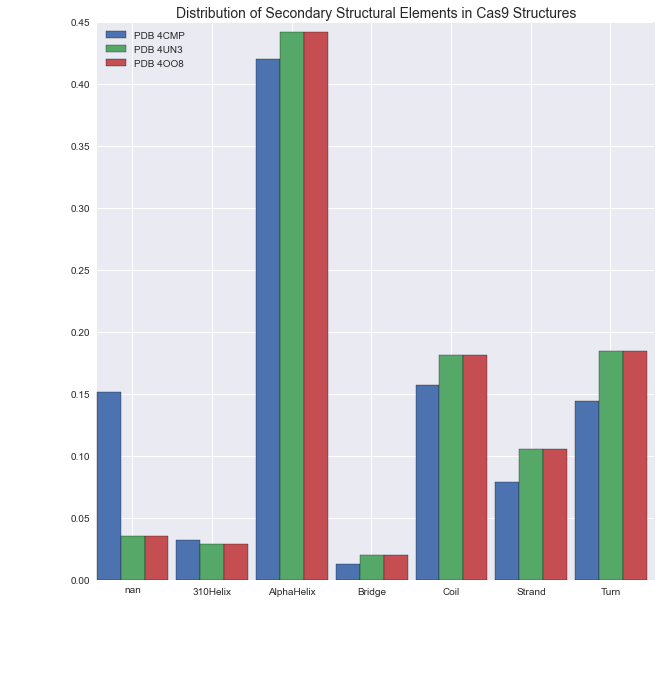

In [4]:
pylab.figure(figsize=(10,10))
xs = np.arange(len(keys))
pallete = seaborn.SEABORN_PALETTES['deep']
pylab.bar(xs, overall_4CMP, width=0.3, color=pallete[0], label='PDB 4CMP')
pylab.bar(xs+0.3, overall_4UN3, width=0.3, color=pallete[1], label='PDB 4UN3')
pylab.bar(xs+0.6, overall_4OO8, width=0.3, color=pallete[2], label='PDB 4OO8')
pylab.xticks(xs + 0.45, keys)
pylab.title('Distribution of Secondary Structural Elements in Cas9 Structures',
            fontsize=14)
pylab.legend(loc=2)
pylab.show()

In [5]:
def pval(p, count, total):
    """
    P-value calculated assuming we are sampling with replacement from
    an overall distribution where the event of interest (secondary structure)
    has a probability of p and all other events have probability q = 1-p.
    
    Single-tailed P-value for the event that the count is as large as observed
    or larger. Not corrected for multiple hypothesis testing etc. 
    """
    q = 1-p
    pvals = [binom(total, i) * (q**(total-i))*(p**i) for i in range(count, total+1)]
    return np.sum(pvals)
    
def plot_ss_elts(ss_elts, overall_dist):
    counts = Counter(ss_elts)
    total = len(ss_elts)
    assert total == np.sum(counts.values())

    keys = sorted(counts.keys(), key=lambda k: counts[k], reverse=True)
    xs = np.arange(len(keys))
    vals = np.array([counts[k] for k in keys])
    pvals = [pval(overall_dist[k], vals[i], total) for i, k in enumerate(keys)]
    normvals = vals / float(total)

    pylab.bar(xs, normvals, width=0.5)
    for i, p in enumerate(pvals):
        yloc = normvals[i] / 2.0
        top = normvals[i]
        xloc = xs[i] + 0.25
        pylab.text(xloc, top + 0.005, 'P = %.2g' % p, ha='center')
        if p < 1e-3:
            pylab.text(xloc, yloc, '**', fontsize=18, ha='center')
        elif p < 0.05:
            pylab.text(xloc, yloc, '*', fontsize=18, ha='center')        
    pylab.xticks(xs + 0.25, keys)


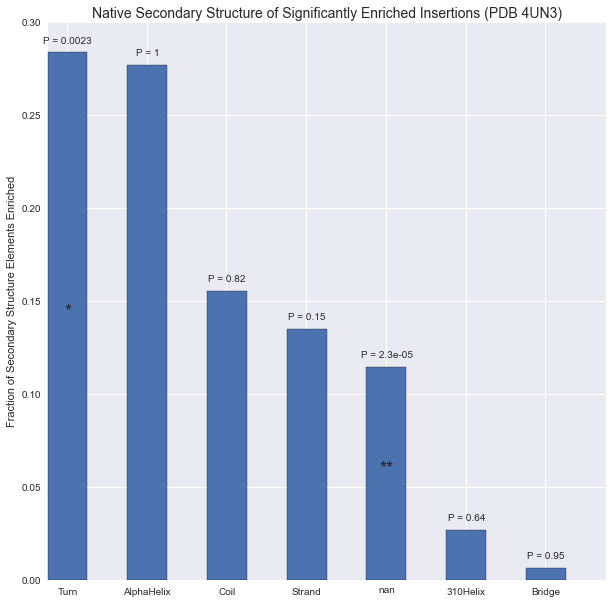

In [6]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4UN3, overall_4UN3_d)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched')
pylab.title('Native Secondary Structure of Significantly Enriched Insertions (PDB 4UN3)', fontsize=14)
pylab.show()

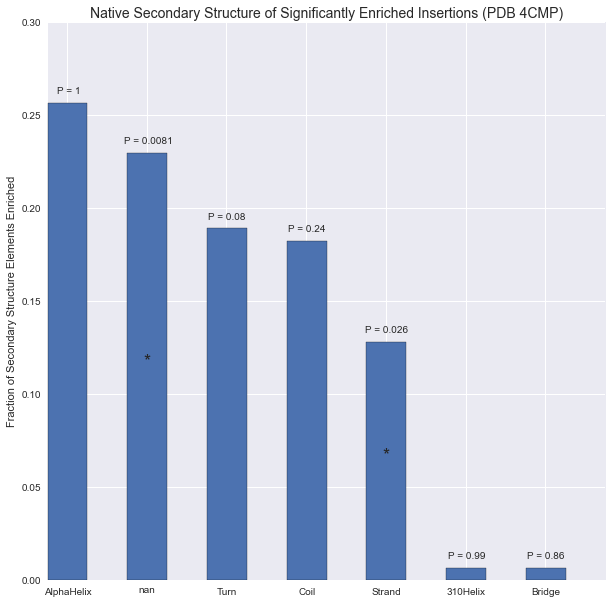

In [7]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4CMP, overall_4CMP_d)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched')
pylab.title('Native Secondary Structure of Significantly Enriched Insertions (PDB 4CMP)', fontsize=14)
pylab.show()

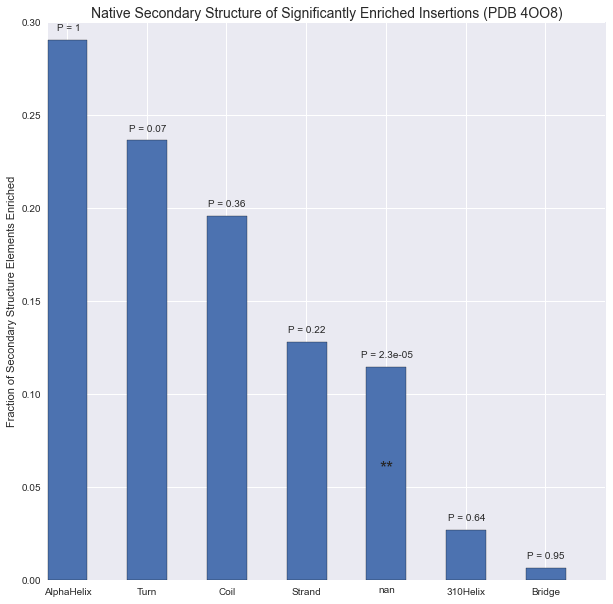

In [8]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4OO8, overall_4OO8_d)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched')
pylab.title('Native Secondary Structure of Significantly Enriched Insertions (PDB 4OO8)', fontsize=14)
pylab.show()